# 01. Perform simulations

/opt/anaconda3/envs/cupy_env/lib/python3.11/site-packages/diffsims/generators/simulation_generator.py:503: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  dot = np.dot(u, diff.T)
/opt/anaconda3/envs/cupy_env/lib/python3.11/site-packages/diffsims/generators/simulation_generator.py:586: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  rho = np.sum((np.dot(o, u)[:, np.newaxis] * u - o) ** 2, axis=1) ** 0.5
100%|██████████| 337/337 [00:07<00:00, 44.17it/s]


(<Axes: xlabel='$\\AA^{-1}$', ylabel='$\\AA^{-1}$'>,
 <matplotlib.collections.PathCollection at 0x14628f290>)

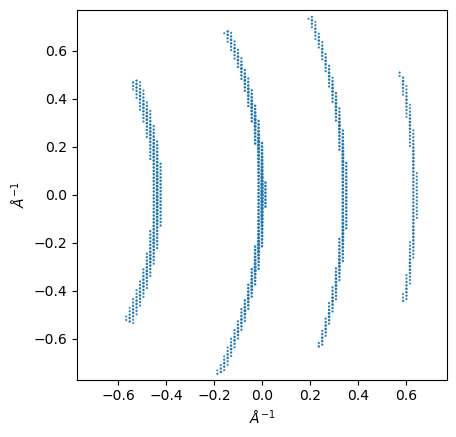

In [1]:
import simserialED.core as simserialED
import h5py
import shutil
import random
from tqdm import tqdm
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Atom, Lattice, Structure
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor

# print("Imports succeeded!")

# Define structure
# can be read from cif:
# p = Phase.from_cif("data/lysozyme.cif") 

# or defined manually:

# a = 80.58 
# b = 94.49 
# c = 103.89 
# al = 90.00 
# be = 90.00 
# ga = 90.00 

# l = Lattice(a, b, c, al, be, ga)

l = Lattice(80.58, 80.9547, 80.9547, 71.4081, 60.153, 60.153)

atoms = [
    Atom("C", (0, 0, 0)),
    # ect.
]
s = Structure(atoms, l)
# p = Phase(space_group=23, structure=s)
p = Phase(space_group=2, structure=s)

# Choose orientations to simulate
# Can sample the symmetry reduced zone of a given point group:
oris = get_sample_reduced_fundamental(
    resolution=10, # degrees, angular distance between simulations
    point_group=p.point_group
) 

# perform simulations
# Initialize simulation generator. This takes in parameters like scattering table, shape factor model ect.
gen = SimulationGenerator(
    accelerating_voltage=300,
)
# Generate simulations for our structure and chosen orientations
sims = gen.calculate_diffraction2d(
    phase=p,
    rotation=oris,
    reciprocal_radius=1/1.3,    # 1/Å, NOT Å. However, 1 1/Å corresponds to 1Å, so in this case it's fine
    max_excitation_error=0.0005,
    with_direct_beam=True, # true/false if we want to include the direct beam
    show_progressbar=True
)
# Note that these simulations are a set of diffraction vectors, with x/y coordinates and intensity, for each orientation. We will later convert this to a diffraction pattern image

# Optionally, plot the simulations.
# This includes a slider to interactively view the different orientations
sims.plot()

# 02. Add simulations to dataset

In [37]:
# Input (original) file
input_filename = "/Users/xiaodong/Desktop/UOXs_radial_backgrounds.h5"

# Output (copy) file
output_filename = "/Users/xiaodong/Desktop/UOXs_radial_backgrounds_combined.h5"

# Make an identical copy of the original file
shutil.copyfile(input_filename, output_filename)

# Now open the copy in read/write mode, so you can modify it safely
with h5py.File(output_filename, "r+") as data:

    images = data["entry"]["data"]["images"]

    # Create (or open if they already exist) new datasets in the copy
    # sim_images = data["entry"]["data"].require_dataset(
    #     "simulation_images", 
    #     shape=images.shape, 
    #     dtype=images.dtype
    # )
    euler_angles = data["entry"]["data"].require_dataset(
        "simulation_euler_angles", 
        shape=(images.shape[0], 3), 
        dtype=float
    )

    shape = images.shape[-2:]
    calibration = 0.0015090274190359715# 1/Å per pixel
    intensity_scale = 1000

    # Assuming you have your simulations in an object called "sims"
    # which provides .current_size, .irot, and .rotations, as before:
    for i in tqdm(range(images.shape[0])):
        # Choose a random in-plane rotation
        in_plane = random.uniform(0, 360)

        # Choose a random simulation
        ind = random.randint(0, sims.current_size - 1)

        # Generate simulation image
        img = sims.irot[ind].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=(shape[0] // 2, shape[1] // 2), # pixel coordinates of direct beam
            sigma=1,                        
            in_plane_angle=in_plane,
            calibration=calibration,
            fast=False
        )

        # Scale image intensity
        img = (img * intensity_scale).astype(images.dtype)

        # Option A: Add the simulation directly to "images" in the new file
        images[i] += img

        # Option B (alternative): If you want a separate combined dataset 
        # so you don't overwrite the original "images", do:
        # combined_images = data["entry"]["data"].require_dataset(
        #     "combined_images",
        #     shape=images.shape,
        #     dtype=images.dtype
        # )
        # combined_images[i] = images[i] + img

        # Store the simulation in a separate dataset
        # sim_images[i] = img

        # Store the Euler angles in the new file
        euler_angles_i = sims.rotations[ind].to_euler(degrees=True).squeeze()
        euler_angles_i[0] = in_plane
        euler_angles[i] = euler_angles_i

print("Done! The combined file is saved at:", output_filename)


100%|██████████| 100/100 [00:01<00:00, 78.25it/s]

Done! The combined file is saved at: /Users/xiaodong/Desktop/UOXs_radial_backgrounds_combined.h5
